<a href="https://colab.research.google.com/github/Leander-csv/DC1/blob/Le-Net5-Neural-Network/LeNet5_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:
In this template, methods are provided to get you started on the task at hand (please see project description). Please implement your solution in the code cells marked with **TODO**. Most of the other code cells are hidden, feel free to explore and change these. These cells implement a basic pipeline for training your model but you may want to explore more complex procedures. **Make sure you run all cells before trying to implement your own solution!**

#Imports:

In [ ]:
#@title
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from torch.autograd import Variable

import pandas as pd
from sklearn.utils import shuffle

class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  
  def __init__(self, x, y, transform=None, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Downloading the data:
The following cells will download the pre-processed X-ray images with their accompanying labels.

The download (400 MB) may take a while.

In [ ]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [ ]:
#@title
# Downloading the images:
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4rwSf9SYO1ydGtK/download')
test_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/dvY2LpvFo6dHef0/download')

# Plotting the data distribution:

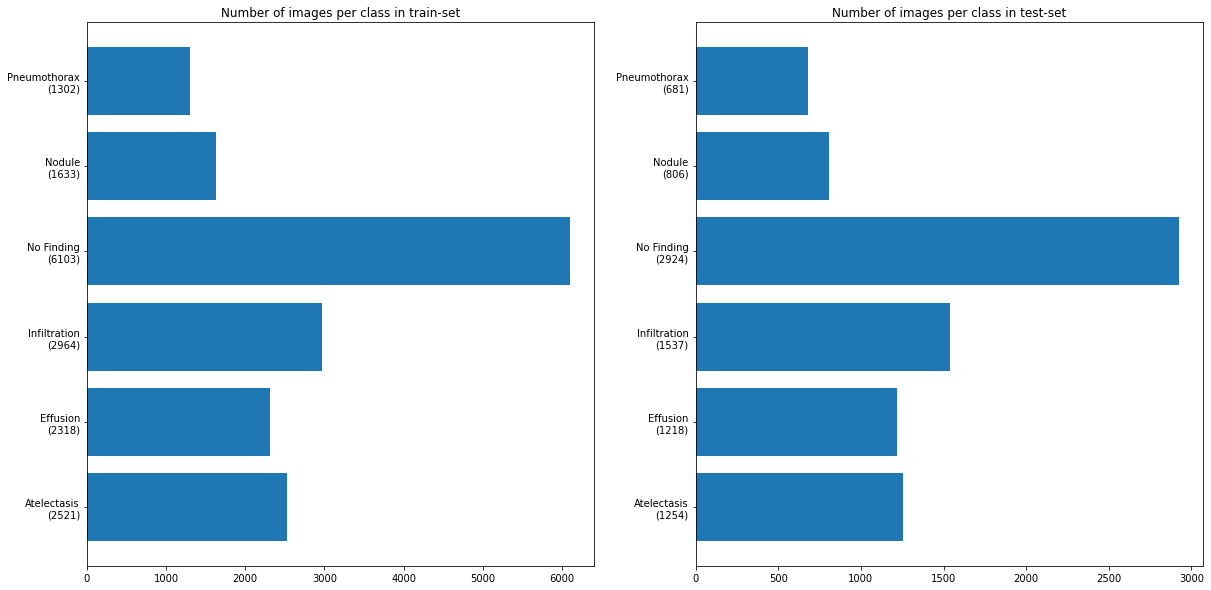

In [ ]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

#Plotting some samples:

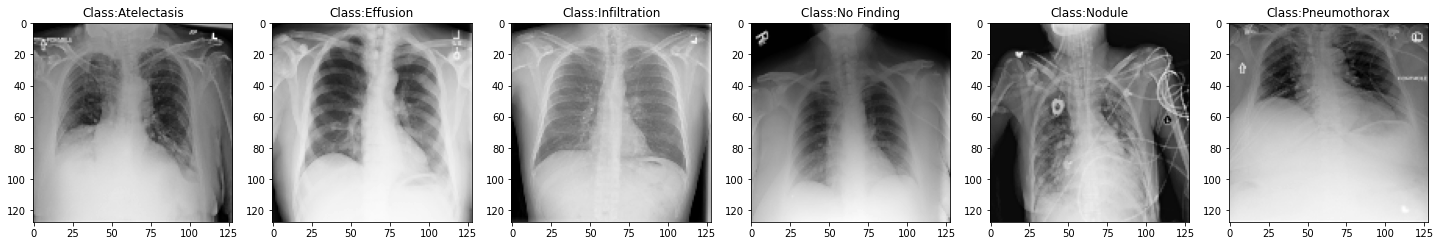

In [ ]:
#@title
# Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

#Building Torch Tensors 


In [ ]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [ ]:
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

TypeError: ignored

#Defining model as LeNet5 Neural Network: 

In [ ]:
class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
		self.conv2 = nn.Conv2d(6, 16, (5,5))
		self.fc1   = nn.Linear(14400, 120)
		self.fc2   = nn.Linear(120, 84)
		self.fc3   = nn.Linear(84, 10)
	def forward(self, x):
		x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
		x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
		x = x.view(-1, self.num_flat_features(x))
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x
	def num_flat_features(self, x):
		size = x.size()[1:]
		num_features = 1
		for s in size:
			num_features *= s
		return num_features
net = LeNet()
 

#Pushing Model to GPU

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
  net = net.cuda()
  print ('USE GPU')
else:
	print ('USE CPU')
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


USE GPU


# Defining our loss and optimizer functions:
**TODO** Please define your own optimizer and loss function.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

#Training our model:

In [ ]:
print ("3. Training phase")
nb_train = train_y.shape[0]
nb_epoch = 75000
nb_index = 0
nb_batch = 4

for epoch in range(nb_epoch):
  if nb_index + nb_batch >= nb_train:
    nb_index = 0
  else:
    nb_index = nb_index + nb_batch

  try:
    mini_data  = Variable(train_x[nb_index:(nb_index+nb_batch)].clone())
    mini_label = Variable(train_y[nb_index:(nb_index+nb_batch)].clone(), requires_grad = False)
    mini_data  = mini_data.type(torch.FloatTensor)
    mini_label = mini_label.type(torch.LongTensor)
    if use_gpu:
      mini_data  = mini_data.cuda()
      mini_label = mini_label.cuda()
      optimizer.zero_grad()
      mini_out   = net(mini_data)
      mini_label = mini_label.view(nb_batch)
      mini_loss  = criterion(mini_out, mini_label)
      mini_loss.backward()
      optimizer.step()
  except: 
    continue



  if (epoch + 1) % 1000 == 0:
    print("Epoch = %d, Loss = %f" %(epoch+1, mini_loss.data))

3. Training phase
Epoch = 1000, Loss = 1.216871
Epoch = 2000, Loss = 1.756102
Epoch = 3000, Loss = 1.998768
Epoch = 4000, Loss = 1.076093
Epoch = 5000, Loss = 1.620056
Epoch = 6000, Loss = 1.471649
Epoch = 7000, Loss = 1.357496
Epoch = 8000, Loss = 2.665668
Epoch = 9000, Loss = 1.506131
Epoch = 10000, Loss = 2.116273
Epoch = 11000, Loss = 2.049496
Epoch = 12000, Loss = 1.108091
Epoch = 13000, Loss = 1.950608
Epoch = 14000, Loss = 2.609582
Epoch = 15000, Loss = 1.275254
Epoch = 16000, Loss = 1.488701
Epoch = 17000, Loss = 1.542602
Epoch = 18000, Loss = 1.241402
Epoch = 19000, Loss = 1.238705
Epoch = 20000, Loss = 1.560762
Epoch = 21000, Loss = 1.418825
Epoch = 22000, Loss = 2.192477
Epoch = 23000, Loss = 1.568952
Epoch = 24000, Loss = 1.617023
Epoch = 25000, Loss = 0.845788
Epoch = 26000, Loss = 0.700584
Epoch = 27000, Loss = 0.618321
Epoch = 28000, Loss = 0.406846
Epoch = 29000, Loss = 0.561577
Epoch = 30000, Loss = 1.644079
Epoch = 31000, Loss = 0.910716
Epoch = 32000, Loss = 1.400711

#Evaluation our model:
**TODO** write your own methods to evaluate the model. For example, calculate the accuracy of the model on the test-set:

In [ ]:
test_x = test_x.unsqueeze(1)
test_x = test_x.to(device)
test_x = test_x.float()

In [ ]:
preds = []

with torch.no_grad():
  for val in test_x: 
    y_hat = net.forward(val)
    preds.append(y_hat.argmax().item())

df = pd.DataFrame({'Y': test_y, 'YHat': preds})

df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]

df['Correct'].sum()/len(df)

0.29133016627078384

This accuracy isn't great. Your task is to find a better model that performs better at the classification task. Other methods of evaluation might tell you more why a particular model is not performing well (accuracy is a quite limited aggregated performance metric). 

#Saving our model:

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# torch.save(model.state_dict(), '/content/gdrive/My Drive/weights_model.txt')